### Price Errors at UCSF/B

This book explores the accuracy of pricing invoiced to UCSF and UC Berkeley versus the Purchase Order.  

In [1]:
import pandas as pd
import numpy as np

%pylab inline

#Read in the data
invoices = pd.read_csv('BuyerInvoice_Data_Berkeley_1_Month_Invoices.csv', low_memory=False, thousands=',')

Populating the interactive namespace from numpy and matplotlib


### Helper Functions
These functions help filter the data and simplify the analysis.  

In [2]:
def FilterInvoices(dataframe):
            dataframe = dataframe[(dataframe['PO No'].str.startswith('B')) &
                     (dataframe['Voucher Status'] != 'Rejected') &
                     (dataframe['Invoice Line Extended Price'] > 0) &
                     (dataframe['Voucher Type'] != 'Credit Memo') &
                     (dataframe['Workflow Status'] == 'Complete') &
                     (dataframe['Line Status'] == 'Approved')]

            #Find all PO's which reference the word "Blanket" as those are probably Blanket POs.
            dataframe['Blanket'] = dataframe['Product Name'].str.contains('blanket', case=False)
            
            #Create the PO feature matrix by creating a pivot table of sums and counts. Then filter out the
            #columns that dont make sense.  The resulting data will look like:
            #PO#--Count of Lines--Count of Invoices--Total $--Dollars Used--Invoice Owner--Campus--Supplier
            PO_pivot = pd.pivot_table(dataframe, rows=['PO No','Supplier Name','Blanket'], 
                       values = ['Voucher Total','Invoice Line Extended Price','PO Line Extended Price','PO Line No','Voucher No'], 
                       aggfunc = [np.sum, lambda x: len(x.unique())])
            
            #create a list of the columns so I can exclude nonsense columns
            cols = PO_pivot.columns.tolist()
            
            #columns I want to exclude (numbering starts with zero)
            indices = 0,1,5,6

            #Run through the column list and remove the indices columns
            cols = [i for j, i in enumerate(cols) if j in indices]
            
            #Create the PO_feature matrix with nicely named columns
            PO_features = PO_pivot[cols].reset_index()
            
            #rename the columns for ease of reference
            PO_features.columns = ['PO No', 'Supplier Name','Blanket Description','Sum Invoice Line Extended Price',
                                   'Sum PO Line Extended Price','Count PO Line No','Count Voucher No']

            #Create the percent of Usage Column
            PO_features['Percent Used'] = PO_features['Sum Invoice Line Extended Price'] / PO_features['Sum PO Line Extended Price']

            #We expect at most 1 voucher per PO Line.
            PO_features['Voucher Per PO Line'] = PO_features['Count Voucher No'] / PO_features['Count PO Line No']
            
            #filter out the outliers; like PO's which have been over invoiced
            PO_features = PO_features[(PO_features['Percent Used'] <= 1)]
            
            #filter out the blankets...  Those with 2 or more vouchers per PO line
            BlanketFilter = PO_features[(PO_features['Voucher Per PO Line'] <= 2)]
            
            return dataframe[dataframe['PO No'].isin(BlanketFilter['PO No'])]

In [7]:
if __name__ == '__main__':
    
    #remove all of the blankets from the analysis
    invoices_filtered = FilterInvoices(invoices)

    #create a new column that is the difference between the Inovice and PO.  Specifically that is the difference
    #between the 'PO line unit price' and the 'Invoice line unit price'
    invoices_filtered['PriceDifference'] = invoices_filtered['PO Line Unit Price'] - invoices_filtered['Invoice Line Unit Price'] 
    


### Create a histogram of the price differences


Discriptive Statistics for price differences
count       28114.000000
mean        53320.653475
std        783383.114011
min         -9749.000000
25%             0.000000
50%             0.000000
75%           494.490000
max      88729562.550000
dtype: float64


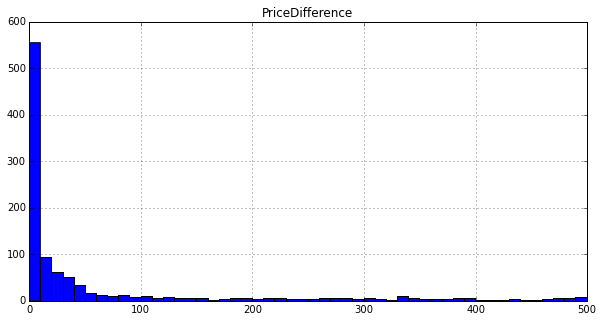

In [43]:
#Analyze the price differences
print
print 'Discriptive Statistics for price differences'
print invoices_filtered['PriceDifference'].describe()

#Filter out the ones that look like outliers
gtZero = invoices_filtered[(invoices_filtered['PriceDifference'] > 0) & (invoices_filtered['PriceDifference'] < 500)] 
gtZero.hist(column='PriceDifference',bins=50,figsize=(10,5));

### Outliers probably matter

Why are we seeing so many invoices with prices greater than the PO line amount.  Specifically, what is going on with the ones that fall in the top 75%?

In [64]:
top25 = invoices_filtered[(invoices_filtered['PriceDifference'] > 495)]

top25.pivot_table(index=['Supplier Name'],
                  values=['PriceDifference'],
                  aggfunc ='count').sort(columns='PriceDifference',ascending=False, axis=0)

,PriceDifference
Supplier Name,
ELIM BIOPHARMACEUTICALS INC,456
BIRITE FOODSERVICE DISTRIBUTORS,374
SAN FRANCISCO SPECIALTY,317
Ratnarkar Inc,253
INTEGRATED DNA TECHNOLOGIES INC,247
VWR INTERNATIONAL INC,243
PRAXAIR DISTRIBUTION,232
Andre-Boudin Bakeries Inc,180
RAISON D'ETRE (SKONES),152
